# UCI : Machine Learning Repository ; World Retail Data -> Spain

In [1]:
import pandas as pd
import datetime
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.datasets import make_circles
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# Purpose of Analysis Spain Retail Data

- 1. Make Spain Retail CRM
- 2. Clustering 'Grade of buyers' aka Montary from Spain CRM Dataframe. 
- 3. Oversee clustering result, compare with actual grade. check accuracy,  2nd Clustering
- 4. if Clustering result is not good enough, take numpy.log() to make values evenly. (used in silhouette score)

# Understanding Results
- Through Spain CRM, identify consumption of patterns
- Divide into Silver, Gold, Diamond

# Futhermore, think about Marketing aspect>
- How do we induce buyers who have not recently purchased to repurchase?
- What product buyers purchased, and how can we predict buyers tendency?
- What product that buyers refund? 


# 1. EDA


- 송장 번호 : 송장 번호. 각 거래에 고유하게 지정된 6 자리 정수입니다. 이 코드가 문자 'c'로 시작하면 취소를 나타냅니다.
- StockCode : 제품 (항목) 코드 각 제품에 고유하게 지정된 5 자리 정수입니다.
- 설명 : 제품 (항목) 이름입니다. 명사 같은.
- 수량 : 거래 당 각 제품 (항목)의 수량입니다. 숫자
- 송장 날짜 : Invice 날짜 및 시간. 숫자, 각 거래가 생성 된 날짜 및 시간입니다.
- 단가 : 단가. 스털링 단위당 숫자, 제품 가격입니다.
- CustomerID : 고객 번호 각 고객에게 고유하게 지정된 5 자리 정수입니다.
- 국가 : 국가 이름. 명목, 각 고객이 거주하는 국가의 이름.


- Invoice number: Invoice number. A six-digit integer uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates cancellation.
- StockCode : Product (item) code is a five-digit integer uniquely assigned to each product.
- Description : Product (item) name. like a noun
- Quantity: Quantity of each product (items) per transaction. Number
- Invoice date : In Device date and time. Numeric, date and time each transaction was created.
- Unit price: unit price. Number per Stirling Unit, product price.
- CustomerID : Customer Number is a five-digit integer uniquely assigned to each customer.
- Country: Country name. Nominal, the name of the country in which each customer resides.  >>In this case, we choose Spain<<

In [3]:
retail_df = pd.read_excel('./Online Retail.xlsx')
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [4]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
retail_df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# 2.  Retail Dataframe Data Processing 
## exclude value that is under zero

In [6]:
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [7]:
print(retail_df.shape)

(397884, 8)


In [8]:
retail_df['Country'].value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

In [9]:
retail_df = retail_df[retail_df['Country']=='Spain']
print(retail_df.shape)

(2484, 8)


In [10]:
retail_df['CustomerID'].unique()

array([12557., 17097., 12540., 12551., 12484., 12539., 12510., 12421.,
       12502., 12462., 12507., 12541., 12547., 12597., 12545., 12596.,
       12354., 12417., 12455., 12450., 12548., 12556., 12550., 12546.,
       12454., 12448., 12544., 12538., 12445., 12442.])

In [11]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2484 entries, 6421 to 535275
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    2484 non-null   object        
 1   StockCode    2484 non-null   object        
 2   Description  2484 non-null   object        
 3   Quantity     2484 non-null   int64         
 4   InvoiceDate  2484 non-null   datetime64[ns]
 5   UnitPrice    2484 non-null   float64       
 6   CustomerID   2484 non-null   float64       
 7   Country      2484 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 174.7+ KB


## RFM Based Data Processing

In [12]:
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [13]:
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

1.0085261875761267

In [14]:
# DataFrame의 groupby() 의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceDate 컬럼의 max() 에서 데이터 가공
# Frequency는 InvoiceNo 컬럼의 count() , Monetary value는 sale_amount 컬럼의 sum()
aggregations = {
    'InvoiceDate': 'max',
    'InvoiceNo': 'count',
    'sale_amount':'sum'
}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
# groupby된 결과 컬럼값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
                                    'InvoiceNo':'Frequency',
                                    'sale_amount':'Monetary'
                                   }
                        )
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12354,2011-04-21 13:11:00,58,1079.40
1,12417,2011-04-28 13:09:00,23,436.30
2,12421,2011-11-24 09:07:00,45,807.04


# 3. Visualization

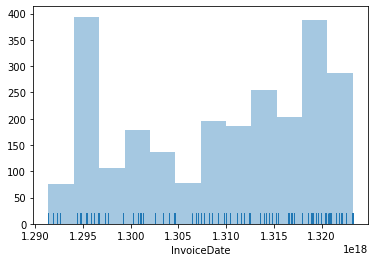

In [15]:
sns.distplot(retail_df['InvoiceDate'], kde=False, rug=True)

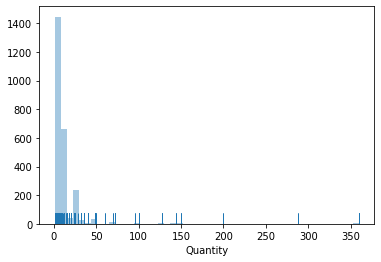

In [16]:
sns.distplot(retail_df['Quantity'], kde=False, rug=True)

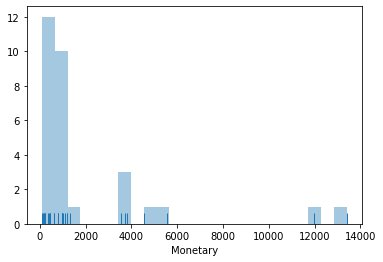

In [17]:
sns.distplot(cust_df['Monetary'], kde=False, rug=True)

# Divide buyers grade in total amounts of consumption
- silver / gold / diamond

In [18]:
cust_df['Grade'] = cust_df['Monetary'].map(lambda x : 'Diamond' if x > 6.0 else('Gold' if x > 4.5 else 'Silver'))
cust_df.head(10)

,CustomerID,Recency,Frequency,Monetary,Grade
0,12354,2011-04-21 13:11:00,58,1079.40,Diamond
1,12417,2011-04-28 13:09:00,23,436.30,Diamond
2,12421,2011-11-24 09:07:00,45,807.04,Diamond
3,12442,2011-12-06 14:22:00,12,172.06,Diamond
4,12445,2011-11-17 18:43:00,4,133.40,Diamond
5,12448,2011-10-26 13:46:00,22,449.45,Diamond
6,12450,2011-07-06 14:41:00,8,197.88,Diamond
7,12454,2011-10-14 17:13:00,15,3528.34,Diamond
8,12455,2011-09-27 15:31:00,48,767.96,Diamond
9,12462,2011-11-21 09:11:00,62,1189.59,Diamond


In [19]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2020,7,23) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df rows & columns ',cust_df.shape)
cust_df.head(3)

cust_df rows & columns  (30, 5)


,CustomerID,Recency,Frequency,Monetary,Grade
0,12354,3381,58,1079.40,Diamond
1,12417,3374,23,436.30,Diamond
2,12421,3164,45,807.04,Diamond


## RFM Visualzation

(array([23.,  0.,  3.,  1.,  1.,  0.,  0.,  0.,  1.,  1.]),
 array([   95.2  ,  1425.704,  2756.208,  4086.712,  5417.216,  6747.72 ,
         8078.224,  9408.728, 10739.232, 12069.736, 13400.24 ]),
 <a list of 10 Patch objects>)

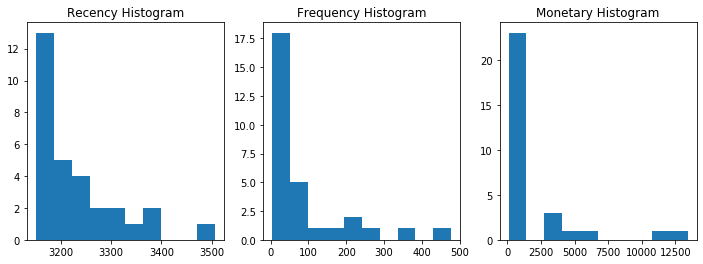

In [20]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

In [21]:
cust_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,30.000000,30.000000,30.000000
mean,3230.333333,82.800000,2052.570333
std,84.544350,113.078063,3230.537911
min,3151.000000,4.000000,95.200000
25%,3171.000000,19.500000,388.600000
50%,3197.000000,39.000000,959.625000
75%,3273.250000,67.250000,1276.005000
max,3506.000000,478.000000,13400.240000


### copy cust_df

In [22]:
cust_df2 =cust_df.copy()

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency','Frequency','Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

실루엣 스코어는 : 0.485


In [24]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

In [25]:
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

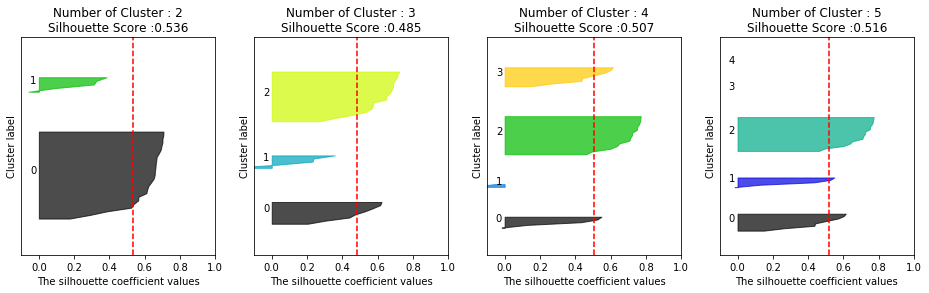

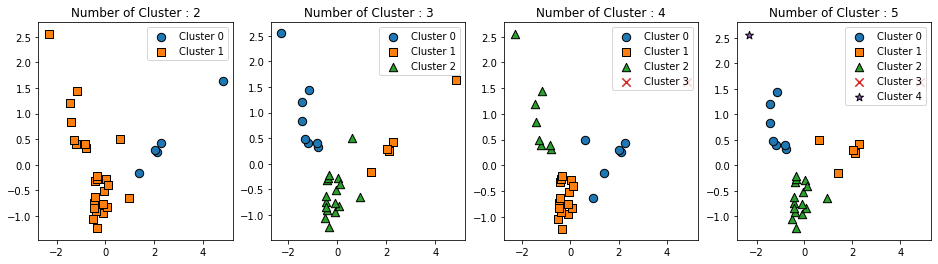

In [26]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

In [27]:
### Log 변환을 통해 데이터 변환
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequecny, Monetary 컬럼에 np.log1p() 로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features = cust_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))


실루엣 스코어는 : 0.398


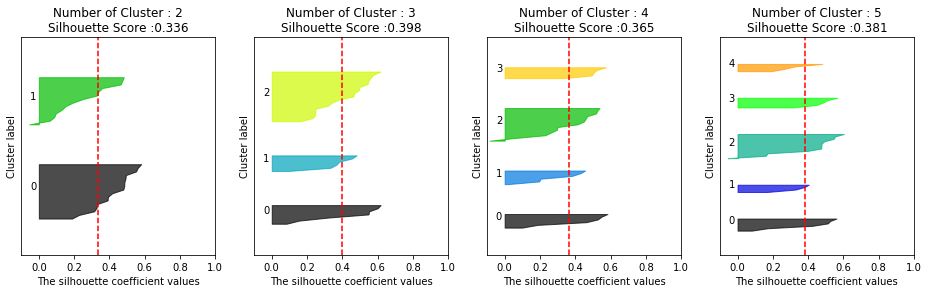

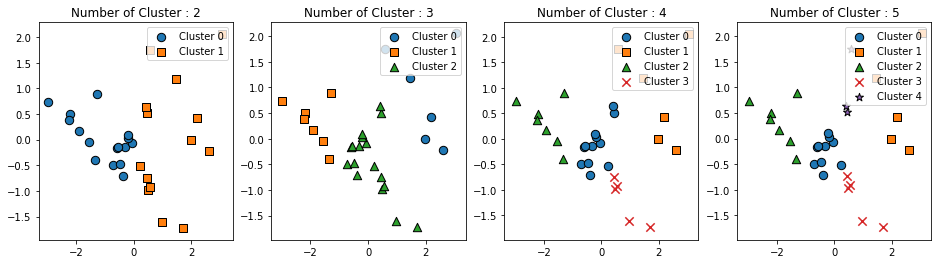

In [28]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

# Divided into 3 Grade

In [29]:
cust_df2.head()

,CustomerID,Recency,Frequency,Monetary,Grade
0,12354,3381,58,1079.40,Diamond
1,12417,3374,23,436.30,Diamond
2,12421,3164,45,807.04,Diamond
3,12442,3152,12,172.06,Diamond
4,12445,3171,4,133.40,Diamond


## define buyers grade based on describe of sales_amounts (mean, 25%, 75%)

In [31]:
cust_df2.describe()

,CustomerID,Recency,Frequency,Monetary
count,30.000000,30.000000,30.000000,30.000000
mean,12658.100000,3230.333333,82.800000,2052.570333
std,840.392369,84.544350,113.078063,3230.537911
min,12354.000000,3151.000000,4.000000,95.200000
25%,12454.250000,3171.000000,19.500000,388.600000
50%,12538.500000,3197.000000,39.000000,959.625000
75%,12547.750000,3273.250000,67.250000,1276.005000
max,17097.000000,3506.000000,478.000000,13400.240000


In [32]:
cust_df2['Monetary'] = np.log1p(cust_df2['Monetary'])
cust_df2.describe()

,CustomerID,Recency,Frequency,Monetary
count,30.000000,30.000000,30.000000,30.000000
mean,12658.100000,3230.333333,82.800000,6.795879
std,840.392369,84.544350,113.078063,1.282880
min,12354.000000,3151.000000,4.000000,4.566429
25%,12454.250000,3171.000000,19.500000,5.962745
50%,12538.500000,3197.000000,39.000000,6.867569
75%,12547.750000,3273.250000,67.250000,7.151485
max,17097.000000,3506.000000,478.000000,9.503103


In [33]:
cust_df2.loc[cust_df2['Monetary'] > 8].count()

CustomerID    7
Recency       7
Frequency     7
Monetary      7
Grade         7
dtype: int64

In [34]:
cust_df2['Grade'] = cust_df2['Monetary'].map(lambda x : 'Diamond' if x > 8.0 else('Gold' if x > 6.8 else 'Silver'))
cust_df2

,CustomerID,Recency,Frequency,Monetary,Grade
0,12354,3381,58,6.985087,Gold
1,12417,3374,23,6.080619,Silver
2,12421,3164,45,6.694612,Silver
3,12442,3152,12,5.153638,Silver
4,12445,3171,4,4.900820,Silver
5,12448,3193,22,6.110247,Silver
6,12450,3305,8,5.292702,Silver
7,12454,3205,15,8.168866,Diamond
8,12455,3222,48,6.645039,Silver
9,12462,3167,62,7.082204,Gold


In [35]:
cust_df3 = cust_df2.copy()

In [36]:
cust_df2.head()

,CustomerID,Recency,Frequency,Monetary,Grade
0,12354,3381,58,6.985087,Gold
1,12417,3374,23,6.080619,Silver
2,12421,3164,45,6.694612,Silver
3,12442,3152,12,5.153638,Silver
4,12445,3171,4,4.900820,Silver


In [37]:
cust_df2['Grade'] = cust_df2['Monetary'].map(lambda x : 2 if x > 8.0  else(1 if x > 6.8 else 0))
cust_df2

,CustomerID,Recency,Frequency,Monetary,Grade
0,12354,3381,58,6.985087,1
1,12417,3374,23,6.080619,0
2,12421,3164,45,6.694612,0
3,12442,3152,12,5.153638,0
4,12445,3171,4,4.900820,0
5,12448,3193,22,6.110247,0
6,12450,3305,8,5.292702,0
7,12454,3205,15,8.168866,2
8,12455,3222,48,6.645039,0
9,12462,3167,62,7.082204,1


In [38]:
cust_df3['Grade'] = cust_df3['Monetary'].map(lambda x : 2 if x > 8.0  else(1 if x > 6.8 else 0))

In [39]:
dbscan = DBSCAN(eps=300, min_samples=3, metric='euclidean') 
dbscan_labels = dbscan.fit_predict(cust_df2)

cust_df2['dbscan_cluster'] = dbscan_labels

cus_result = cust_df2.groupby(['Grade'])['dbscan_cluster'].value_counts()
print(cus_result)

Grade  dbscan_cluster
0       0                14
1       0                 8
       -1                 1
2       0                 7
Name: dbscan_cluster, dtype: int64


In [40]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수  
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

# outliners = -1, we have 2 outliners

In [41]:
dbscan_labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1], dtype=int64)

In [42]:
cust_df2

,CustomerID,Recency,Frequency,Monetary,Grade,dbscan_cluster
0,12354,3381,58,6.985087,1,0
1,12417,3374,23,6.080619,0,0
2,12421,3164,45,6.694612,0,0
3,12442,3152,12,5.153638,0,0
4,12445,3171,4,4.900820,0,0
5,12448,3193,22,6.110247,0,0
6,12450,3305,8,5.292702,0,0
7,12454,3205,15,8.168866,2,0
8,12455,3222,48,6.645039,0,0
9,12462,3167,62,7.082204,1,0


In [43]:
dfff = cust_df2.copy()
dfff[dfff['Grade']==dfff['dbscan_cluster']].count()

CustomerID        14
Recency           14
Frequency         14
Monetary          14
Grade             14
dbscan_cluster    14
dtype: int64

In [44]:
print('Afer Clustering Accuracy :', round(13/ 29 * 100),2, '%')

Afer Clustering Accuracy : 45 2 %


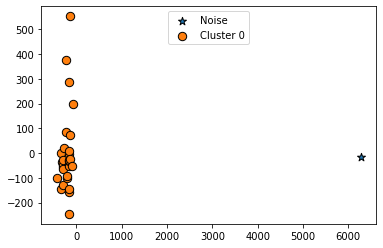

In [48]:
# 2차원으로 시각화하기 위해 PCA n_componets=2로 피처 데이터 세트 변환
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(cust_df2)
# visualize_cluster_2d( ) 함수는 ftr1, ftr2 컬럼을 좌표에 표현하므로 PCA 변환값을 해당 컬럼으로 생성
cust_df2['ftr1'] = pca_transformed[:,0]
cust_df2['ftr2'] = pca_transformed[:,1]

visualize_cluster_plot(dbscan, cust_df2, 'dbscan_cluster', iscenter=False)

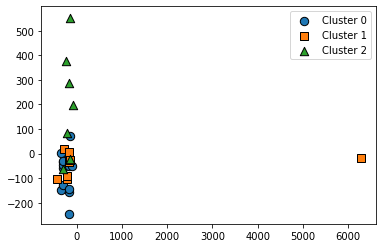

In [49]:
from sklearn.datasets import make_circles

clusterDF = pd.DataFrame(data=cust_df2, columns=['ftr1', 'ftr2'])
clusterDF['target'] = cust_df2['Grade']

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

# We've been clustering through DBSCAN. Noise made it difficult to visualize. Proceed DBSCAN again after noise rejection.

In [60]:
cust_df2.loc[cust_df2['dbscan_cluster'] == -1]

,CustomerID,Recency,Frequency,Monetary,Grade,dbscan_cluster,ftr1,ftr2
16,12540,3168,478,9.503103,2,-1,878.367652,55.629036


In [52]:
cust_df2.drop(cust_df2.index[29], inplace = True)
cust_df2

,CustomerID,Recency,Frequency,Monetary,Grade,dbscan_cluster,ftr1,ftr2
0,12354,3381,58,6.985087,1,0,-532.691205,-125.365237
1,12417,3374,23,6.080619,0,0,-425.298973,-179.885548
2,12421,3164,45,6.694612,0,0,-410.235438,1.267347
3,12442,3152,12,5.153638,0,0,-375.267404,-43.965126
4,12445,3171,4,4.900820,0,0,-371.135001,-70.087173
5,12448,3193,22,6.110247,0,0,-365.700944,-57.100506
6,12450,3305,8,5.292702,0,0,-366.702623,-157.571361
7,12454,3205,15,8.168866,2,0,-356.089769,-76.894165
8,12455,3222,48,6.645039,0,0,-353.144118,-36.587302
9,12462,3167,62,7.082204,1,0,-338.451944,23.544710


In [58]:
dbscan = DBSCAN(eps=300, min_samples=2, metric='euclidean') 
dbscan_labels = dbscan.fit_predict(cust_df2)

cust_df2['dbscan_cluster'] = dbscan_labels

cus_result = cust_df2.groupby(['Grade'])['dbscan_cluster'].value_counts()
print(cus_result)

Grade  dbscan_cluster
0       0                14
1       0                 8
2       0                 6
       -1                 1
Name: dbscan_cluster, dtype: int64


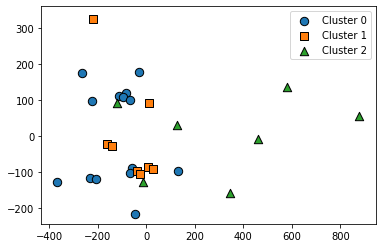

In [59]:
from sklearn.datasets import make_circles

clusterDF = pd.DataFrame(data=cust_df2, columns=['ftr1', 'ftr2'])
clusterDF['target'] = cust_df2['Grade']

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

### Futhermore, think from a marketing prospective >
- How do we induce buyers who have not recently purchased to repurchase?
- What product buyers purchased, and how can we predict buyers tendency?
-- ★ -> NOW WORKING ON...
- What product that buyers refund? 

### 1. How do we induce buyers who have not recently purchased to repurchase?
- First, find dataframe order by Frequency, Recency by ascending = False, then we can find buyers who didn't buy recently.
- give coupon to customers

In [102]:
pd.set_option('display.max_colwidth',-1)

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [61]:
repurchase = cust_df.sort_values(['Frequency'], ascending=True)

In [62]:
repurchase.head(5)

,CustomerID,Recency,Frequency,Monetary,Grade,cluster_label,Recency_log,Frequency_log,Monetary_log
4,12445,3171,4,133.40,Diamond,2,8.062118,1.609438,4.900820
22,12548,3315,5,95.20,Diamond,1,8.106515,1.791759,4.566429
21,12547,3346,8,207.80,Diamond,1,8.115820,2.197225,5.341377
6,12450,3305,8,197.88,Diamond,1,8.103494,2.197225,5.292702
24,12551,3506,10,168.00,Diamond,1,8.162516,2.397895,5.129899


### 2. What product buyers purchased, and how can we predict buyers tendency?
- First, pick random Customer.
- Second, Make a new Dataframe that contains CustomerId and things they bought.

In [63]:
repurchase.tail(5)

,CustomerID,Recency,Frequency,Monetary,Grade,cluster_label,Recency_log,Frequency_log,Monetary_log
28,12597,3168,206,3811.22,Diamond,0,8.061171,5.332719,8.245967
29,17097,3151,211,954.42,Diamond,0,8.055792,5.356586,6.862151
15,12539,3171,273,5568.35,Diamond,0,8.062118,5.613128,8.625034
10,12484,3181,346,4541.72,Diamond,0,8.065265,5.849325,8.421281
16,12540,3168,478,13400.24,Diamond,0,8.061171,6.171701,9.503103


In [233]:
r = repurchase.copy()
predict_tendency = r[['CustomerID']]
fre = r['Frequency']
predict_tendency.head()

,CustomerID
4,12445
22,12548
21,12547
6,12450
24,12551


In [234]:
pre = predict_tendency['CustomerID'].to_numpy()
pre

array([12445, 12548, 12547, 12450, 12551, 12442, 12454, 12544, 12538,
       12507, 12448, 12417, 12596, 12510, 12557, 12421, 12455, 12545,
       12541, 12550, 12354, 12462, 12546, 12556, 12502, 12597, 17097,
       12539, 12484, 12540], dtype=int64)

In [235]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sale_amount
6421,536944,22383,LUNCH BAG SUKI DESIGN,70,2010-12-03 12:20:00,1.65,12557,Spain,115.5
6422,536944,22384,LUNCH BAG PINK POLKADOT,100,2010-12-03 12:20:00,1.45,12557,Spain,145.0
6423,536944,20727,LUNCH BAG BLACK SKULL.,60,2010-12-03 12:20:00,1.65,12557,Spain,99.0
6424,536944,20725,LUNCH BAG RED RETROSPOT,70,2010-12-03 12:20:00,1.65,12557,Spain,115.5
6425,536944,20728,LUNCH BAG CARS BLUE,100,2010-12-03 12:20:00,1.45,12557,Spain,145.0


In [236]:
predict_tendency['Shopping_list'] = 'a'
predict_tendency

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,CustomerID,Shopping_list
4,12445,a
22,12548,a
21,12547,a
6,12450,a
24,12551,a
3,12442,a
7,12454,a
18,12544,a
14,12538,a
12,12507,a


In [374]:
p = []
for i in range(len(pre)) :
    p.append(int(pre[i]))
p

[12445,
 12548,
 12547,
 12450,
 12551,
 12442,
 12454,
 12544,
 12538,
 12507,
 12448,
 12417,
 12596,
 12510,
 12557,
 12421,
 12455,
 12545,
 12541,
 12550,
 12354,
 12462,
 12546,
 12556,
 12502,
 12597,
 17097,
 12539,
 12484,
 12540]

In [375]:
for num in range(len(p)) :
    num = p[num]
    cnt = 0
    description_arr = retail_df.loc[retail_df['CustomerID'] ==num][['Description']].to_numpy()
    des = []
    for j in range(len(description_arr)) :
        split_descript = description_arr[j].tolist()
        sd = str(split_descript).split()
        s = []
        for i in range(len(sd)) :
            if sd[i] != "['" or sd[i] != '"]':
                if sd[i].find('"]') :
                    word = sd[i]
                    #word = word[:-1]
                    s.append(word)
        split_descript = s 
        if len(split_descript) != 1 :
            split_descript = split_descript[-2:]
            final_b = split_descript[0].replace(' ','')
            if str(final_b).find("['") != 1 :
                s = split_descript[1].split("'")
            if len(s[0]) != 0 :
                if s[0].find("]'") != 1 :
                    final_b += ' '+ s[0].replace(' ', '')
            des.append(final_b)
        else :
            final_b = str(split_descript[0]).split("'")
            des.append(final_b[1])
            if final_b[1] == 'POSTAGE':
                cnt += 1
    predict_tendency.loc[predict_tendency['CustomerID']== num, 'Shopping_list'] = str(des)
    predict_tendency.loc[predict_tendency['CustomerID']== num, 'Postage'] = int(cnt)

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [239]:
'''
num = p[4]

description_arr = retail_df.loc[retail_df['CustomerID'] ==num][['Description']].to_numpy()
des = []
for j in range(len(description_arr)) :
    split_descript = description_arr[j].tolist()
    sd = str(split_descript).split()
    s = []
    for i in range(len(sd)) :
        if sd[i] != "['" or sd[i] != '"]':
            if sd[i].find('"]') :
                word = sd[i]
                #word = word[:-1]
                s.append(word)
    split_descript = s 
    if len(split_descript) != 1 :
        split_descript = split_descript[-2:]
        final_b = split_descript[0].replace(' ','')
        if str(final_b).find("['") != 1 :
            s = split_descript[1].split("'")
        if len(s[0]) != 0 :
            if s[0].find("]'") != 1 :
                final_b += ' '+ s[0].replace(' ', '')
        des.append(final_b)
    else :
        final_b = str(split_descript[0]).split("'")
        des.append(final_b[1])
        if final_b[1] == 'POSTAGE':
            cnt += 1
predict_tendency.loc[predict_tendency['CustomerID']== num, 'Shopping_list'] = str(des)
predict_tendency.loc[predict_tendency['CustomerID']== num, 'Postage'] = int(cnt)


'''

In [247]:
predict_tendency.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 4 to 16
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     30 non-null     int64  
 1   Shopping_list  30 non-null     object 
 2   Postage        30 non-null     float64
 3   Frequency      30 non-null     int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 1.2+ KB


In [248]:
predict_tendency.shape

(30, 4)

In [376]:
predict_tendency.head(7)

,CustomerID,Shopping_list,Postage,Frequency,Buy_in_one_time,Classify_Shopping_list,Frequency_Shopping_list
4,12445,"['BOXED CANDLES', 'BELL', 'BOXED CANDLES', 'POSTAGE']",1.0,4,4.0,"[(PAPER, 3), (DOILIES, 3), (COOKIE, 1), (CUTTERS, 1)]",a
22,12548,"['PAPER DOILIES', 'PAPER DOILIES', 'PAPER DOILIES', 'COOKIE CUTTERS', 'POSTAGE']",1.0,5,5.0,"{'[': 1, ''': 10, 'P': 7, 'A': 4, 'E': 9, 'R': 4, ' ': 8, 'D': 3, 'O': 6, 'I': 7, 'L': 3, 'S': 5, ',': 4, 'C': 2, 'K': 1, 'U': 1, 'T': 3, 'G': 1, ']': 1}",a
21,12547,"['CANDY ASSORTED', 'CARNIVAL ASSORTED', 'GIFT BOXES', 'SHAPE CUP', 'SHAPE CUP', 'POSTAGE', 'NAPKINS', 'POSTAGE']",2.0,8,4.0,"{'[': 1, ''': 16, 'C': 4, 'A': 10, 'N': 4, 'D': 3, 'Y': 1, ' ': 12, 'S': 10, 'O': 5, 'R': 3, 'T': 5, 'E': 7, ',': 7, 'I': 3, 'V': 1, 'L': 1, 'G': 3, 'F': 1, 'B': 1, 'X': 1, 'H': 2, 'P': 7, 'U': 2, 'K': 1, ']': 1}",a
6,12450,"['DINER ASSORTED', 'GROCERY MAGNETS', 'DAY MAGNETS', 'JAR', 'CHOCOLATE CUPCAKES', 'PATTERN', 'PATTERN', 'TEA MUG']",0.0,8,0.0,"{'[': 1, ''': 16, 'D': 3, 'I': 1, 'N': 5, 'E': 10, 'R': 7, ' ': 12, 'A': 10, 'S': 5, 'O': 4, 'T': 9, ',': 7, 'G': 4, 'C': 5, 'Y': 2, 'M': 3, 'J': 1, 'H': 1, 'L': 1, 'U': 2, 'P': 3, 'K': 1, ']': 1}",a
24,12551,"['BLACK WHITE', 'RED RETROSPOT', 'PINK POLKADOT', 'SCANDINAVIAN PAISLEY', 'WOODLAND ANIMALS', 'SHOPPER BAG', 'SHOPPER BAG', 'SHOPPER BAG', 'SHOULDER BAG', 'SHOULDER BAG']",0.0,10,0.0,"{'[': 1, ''': 20, 'B': 6, 'L': 7, 'A': 14, 'C': 2, 'K': 3, ' ': 19, 'W': 2, 'H': 6, 'I': 6, 'T': 4, 'E': 9, ',': 9, 'R': 8, 'D': 7, 'O': 11, 'S': 9, 'P': 10, 'N': 6, 'V': 1, 'Y': 1, 'M': 1, 'G': 5, 'U': 2, ']': 1}",a
3,12442,"['FLOWER DOILIES', 'PAISLEY PARK', 'BUNTING RETROSPOT', 'HONEYCOMB FAN', 'TISSUES', 'TISSUES', 'TISSUES', 'PAPER PLATES', 'PAPER CUPS', 'PARK', 'PARTY CANDLES', 'POSTAGE']",1.0,12,12.0,"[(BOXED, 2), (CANDLES, 2)]",a
7,12454,"['WHITE', 'WHITE FINISH', 'WOOD CABINET', '3 TIER', 'FRENCH CHATEAU', 'WHITE FINISH', 'CHANDELIER', 'T-LIGHT HOLDER', 'T-LIGHT HOLDER', 'T-LIGHT HOLDER', 'BOX SILVER', 'BOX GOLD', 'CAKE TINS', 'JEWELLED BOX', 'JEWELLED BOX']",0.0,15,0.0,"[(MAGNETS, 2), (DINER, 1), (ASSORTED, 1), (GROCERY, 1), (DAY, 1), (CHOCOLATE, 1), (CUPCAKES, 1), (TEA, 1), (MUG, 1)]",a


In [250]:
predict_tendency.tail(3)

CustomerID  \
15  12539        
10  12484        
16  12540        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [251]:
predict_tendency['Frequency'] = fre
predict_tendency

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,CustomerID,Shopping_list,Postage,Frequency
4,12445,"['BOXED CANDLES', 'BELL', 'BOXED CANDLES', 'POSTAGE']",1.0,4
22,12548,"['PAPER DOILIES', 'PAPER DOILIES', 'PAPER DOILIES', 'COOKIE CUTTERS', 'POSTAGE']",1.0,5
21,12547,"['CANDY ASSORTED', 'CARNIVAL ASSORTED', 'GIFT BOXES', 'SHAPE CUP', 'SHAPE CUP', 'POSTAGE', 'NAPKINS', 'POSTAGE']",2.0,8
6,12450,"['DINER ASSORTED', 'GROCERY MAGNETS', 'DAY MAGNETS', 'JAR', 'CHOCOLATE CUPCAKES', 'PATTERN', 'PATTERN', 'TEA MUG']",0.0,8
24,12551,"['BLACK WHITE', 'RED RETROSPOT', 'PINK POLKADOT', 'SCANDINAVIAN PAISLEY', 'WOODLAND ANIMALS', 'SHOPPER BAG', 'SHOPPER BAG', 'SHOPPER BAG', 'SHOULDER BAG', 'SHOULDER BAG']",0.0,10
3,12442,"['FLOWER DOILIES', 'PAISLEY PARK', 'BUNTING RETROSPOT', 'HONEYCOMB FAN', 'TISSUES', 'TISSUES', 'TISSUES', 'PAPER PLATES', 'PAPER CUPS', 'PARK', 'PARTY CANDLES', 'POSTAGE']",1.0,12
7,12454,"['WHITE', 'WHITE FINISH', 'WOOD CABINET', '3 TIER', 'FRENCH CHATEAU', 'WHITE FINISH', 'CHANDELIER', 'T-LIGHT HOLDER', 'T-LIGHT HOLDER', 'T-LIGHT HOLDER', 'BOX SILVER', 'BOX GOLD', 'CAKE TINS', 'JEWELLED BOX', 'JEWELLED BOX']",0.0,15
18,12544,"['WITH JARS', 'RUSTIC CHARM', ""50'S CHRISTMAS"", 'VINTAGE CHRISTMAS', 'VINTAGE CHRISTMAS', 'CHRISTMAS RIBBONS', 'REDS RIBBONS', 'LITTLE FRIENDS', 'BIRD ORNAMENT', 'EMILY', 'REEL ROSIE', 'SALLY', 'DOILY', 'TRINKET BOX', 'OLIVIA DOLL', 'LOLA DOLL', 'KNITTING NANCY', 'MINI CASES', 'POSTAGE']",1.0,19
14,12538,"['3 TIER', 'COVER', 'TAG', 'LOVE LONDON', 'AIRMAIL', 'RESPECTABLE HOUSE', 'WITH JARS', 'PORTRAIT FRAME', 'LONDON', 'LONDON', 'MINI CASES', 'PEN RED', 'BABY PINK', 'PEN FUSCHIA', 'SHOPPING LIST', 'PASSPORT COVER', 'TAG', 'EXERCISE BOOKS', 'MAGNETIC NOTEPAD', 'TINS LEAF', 'DESIGN']",0.0,21
12,12507,"['PC', 'TUBE WOODLAND', 'GIFT TAGS', 'WITH JARS', 'COOKIE CUTTERS', 'COOKIE CUTTERS', 'CUTTERS SET', 'COOKIE CUTTERS', 'CASES', 'CAKE CASES', 'CHOCOLATE CUPCAKES', 'T-LIGHT HOLDER', 'POSTAGE', 'WITH JARS', '3 TIER', 'BAKING CASES', 'FOUR CASES', 'BAKING CASES', 'BAKING CASES', 'BAKING CASES', 'POSTAGE']",2.0,21


In [256]:
predict_tendency['Buy_in_one_time'] = 1.0

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [257]:
predict_tendency.loc[predict_tendency['Postage'] != 0, 'Buy_in_one_time'] = round(predict_tendency['Frequency'] / predict_tendency['Postage'],2)
predict_tendency.loc[predict_tendency['Postage'] == 0, 'Buy_in_one_time'] = 0
predict_tendency

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,CustomerID,Shopping_list,Postage,Frequency,Buy_in_one_time
4,12445,"['BOXED CANDLES', 'BELL', 'BOXED CANDLES', 'POSTAGE']",1.0,4,4.00
22,12548,"['PAPER DOILIES', 'PAPER DOILIES', 'PAPER DOILIES', 'COOKIE CUTTERS', 'POSTAGE']",1.0,5,5.00
21,12547,"['CANDY ASSORTED', 'CARNIVAL ASSORTED', 'GIFT BOXES', 'SHAPE CUP', 'SHAPE CUP', 'POSTAGE', 'NAPKINS', 'POSTAGE']",2.0,8,4.00
6,12450,"['DINER ASSORTED', 'GROCERY MAGNETS', 'DAY MAGNETS', 'JAR', 'CHOCOLATE CUPCAKES', 'PATTERN', 'PATTERN', 'TEA MUG']",0.0,8,0.00
24,12551,"['BLACK WHITE', 'RED RETROSPOT', 'PINK POLKADOT', 'SCANDINAVIAN PAISLEY', 'WOODLAND ANIMALS', 'SHOPPER BAG', 'SHOPPER BAG', 'SHOPPER BAG', 'SHOULDER BAG', 'SHOULDER BAG']",0.0,10,0.00
3,12442,"['FLOWER DOILIES', 'PAISLEY PARK', 'BUNTING RETROSPOT', 'HONEYCOMB FAN', 'TISSUES', 'TISSUES', 'TISSUES', 'PAPER PLATES', 'PAPER CUPS', 'PARK', 'PARTY CANDLES', 'POSTAGE']",1.0,12,12.00
7,12454,"['WHITE', 'WHITE FINISH', 'WOOD CABINET', '3 TIER', 'FRENCH CHATEAU', 'WHITE FINISH', 'CHANDELIER', 'T-LIGHT HOLDER', 'T-LIGHT HOLDER', 'T-LIGHT HOLDER', 'BOX SILVER', 'BOX GOLD', 'CAKE TINS', 'JEWELLED BOX', 'JEWELLED BOX']",0.0,15,0.00
18,12544,"['WITH JARS', 'RUSTIC CHARM', ""50'S CHRISTMAS"", 'VINTAGE CHRISTMAS', 'VINTAGE CHRISTMAS', 'CHRISTMAS RIBBONS', 'REDS RIBBONS', 'LITTLE FRIENDS', 'BIRD ORNAMENT', 'EMILY', 'REEL ROSIE', 'SALLY', 'DOILY', 'TRINKET BOX', 'OLIVIA DOLL', 'LOLA DOLL', 'KNITTING NANCY', 'MINI CASES', 'POSTAGE']",1.0,19,19.00
14,12538,"['3 TIER', 'COVER', 'TAG', 'LOVE LONDON', 'AIRMAIL', 'RESPECTABLE HOUSE', 'WITH JARS', 'PORTRAIT FRAME', 'LONDON', 'LONDON', 'MINI CASES', 'PEN RED', 'BABY PINK', 'PEN FUSCHIA', 'SHOPPING LIST', 'PASSPORT COVER', 'TAG', 'EXERCISE BOOKS', 'MAGNETIC NOTEPAD', 'TINS LEAF', 'DESIGN']",0.0,21,0.00
12,12507,"['PC', 'TUBE WOODLAND', 'GIFT TAGS', 'WITH JARS', 'COOKIE CUTTERS', 'COOKIE CUTTERS', 'CUTTERS SET', 'COOKIE CUTTERS', 'CASES', 'CAKE CASES', 'CHOCOLATE CUPCAKES', 'T-LIGHT HOLDER', 'POSTAGE', 'WITH JARS', '3 TIER', 'BAKING CASES', 'FOUR CASES', 'BAKING CASES', 'BAKING CASES', 'BAKING CASES', 'POSTAGE']",2.0,21,10.50


## How many things buy in one purchase

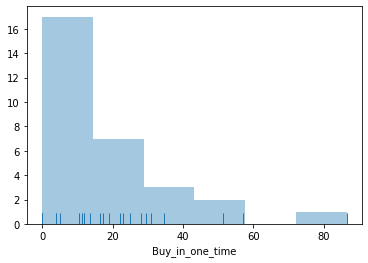

In [258]:
sns.distplot(predict_tendency['Buy_in_one_time'], kde=False, rug=True)

In [265]:
group_A = 0
group_B = 0
group_C = 0
predict_tendency[['Buy_in_one_time']].describe()

,Buy_in_one_time
count,30.000000
mean,17.103333
std,20.128694
min,0.000000
25%,0.000000
50%,12.000000
75%,24.500000
max,86.500000


In [271]:
for i in predict_tendency.index:
    times = predict_tendency['Buy_in_one_time'][i]
    if times <= 10 : #50%
        group_A += 1
    elif times < 30 : #75%
        group_B += 1
    else :
        group_C += 1

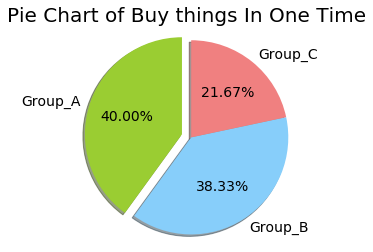

In [272]:
# information of groups

group_names = ['Group_A', 'Group_B', 'Group_C']
group_sizes = [group_A, group_B,group_C]
group_colors = ['yellowgreen', 'lightskyblue', 'lightcoral']
group_explodes = (0.1, 0, 0) # explode 1st slice


plt.pie(group_sizes, 
        explode=group_explodes, 
        labels=group_names, 
        colors=group_colors, 
        autopct='%1.2f%%',
        shadow=True, 
        startangle=90,
        textprops={'fontsize': 14}) 

plt.axis('equal') 
plt.title('Pie Chart of Buy things In One Time', fontsize=20)
plt.show()

## There were the most people who bought less than 10 each time. (Group_A). Group_C  is probably a wholesaler

# 
# Analyze in detail.
## each customers have their own Shopping_list. make dictionary type and count frequency.

In [273]:
predict_tendency2 = predict_tendency.copy()

In [385]:
 predict_tendency['Classify_Shopping_list'] = 'a'

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [386]:
 predict_tendency['Frequency_Shopping_list'] = 'a'

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [364]:
'''
tt = predict_tendency['Shopping_list'][0]
li = {}
li2 = {}
def isOnlyChar(a) :
    result = ''
    for i in range(len(a)):
        if a[i] == ' ':
            if a[i-1].isalpha():
                if a[i+1].isalpha():
                    result += ' '
        if a[i].isalpha():
            result += a[i]
    return result

tt2 = tt.split(',')
for i in range(len(tt2)) :
    p = isOnlyChar(tt2[i])
    if p in li :
        li[p] += 1
    else :
        li[p] = 1
        
    if ' ' in p :
        p1 = p.split(' ')
        if p1[0] in li2:
            li2[p1[0]] += 1
        else :
            li2[p1[0]] = 1
        if p1[1] in li2:
            li2[p1[1]] += 1
        else :
            li2[p1[1]] = 1
print(li)
print(' specify')
dicArr = sorted(li2.items(), key=lambda x: x[1], reverse=True)
print(dicArr[:30])
'''

"\ntt = predict_tendency['Shopping_list'][0]\nli = {}\nli2 = {}\ndef isOnlyChar(a) :\n    result = ''\n    for i in range(len(a)):\n        if a[i] == ' ':\n            if a[i-1].isalpha():\n                if a[i+1].isalpha():\n                    result += ' '\n        if a[i].isalpha():\n            result += a[i]\n    return result\n\ntt2 = tt.split(',')\nfor i in range(len(tt2)) :\n    p = isOnlyChar(tt2[i])\n    if p in li :\n        li[p] += 1\n    else :\n        li[p] = 1\n        \n    if ' ' in p :\n        p1 = p.split(' ')\n        if p1[0] in li2:\n            li2[p1[0]] += 1\n        else :\n            li2[p1[0]] = 1\n        if p1[1] in li2:\n            li2[p1[1]] += 1\n        else :\n            li2[p1[1]] = 1\nprint(li)\nprint(' specify')\ndicArr = sorted(li2.items(), key=lambda x: x[1], reverse=True)\nprint(dicArr[:30])\n"

In [381]:
for i in predict_tendency.index: 
    print(predict_tendency['CustomerID'][i])

12445
12548
12547
12450
12551
12442
12454
12544
12538
12507
12448
12417
12596
12510
12557
12421
12455
12545
12541
12550
12354
12462
12546
12556
12502
12597
17097
12539
12484
12540


In [387]:
def isOnlyChar(a) :
        result = ''
        for i in range(len(a)):
            if a[i] == ' ':
                if a[i-1].isalpha():
                    if a[i+1].isalpha():
                        result += ' '
            if a[i].isalpha():
                result += a[i]
        return result

for i in predict_tendency.index:    
    tt = predict_tendency['Shopping_list'][i]
    li = {}
    li2 = {}
    
    tt2 = tt.split(',')
    for j in range(len(tt2)) :
        p = isOnlyChar(tt2[j])
        if p in li :
            li[p] += 1
        else :
            li[p] = 1

        if ' ' in p :
            p1 = p.split(' ')
            if p1[0] in li2:
                li2[p1[0]] += 1
            else :
                li2[p1[0]] = 1
            if p1[1] in li2:
                li2[p1[1]] += 1
            else :
                li2[p1[1]] = 1
    predict_tendency['Classify_Shopping_list'][i] = li
    dicArr = sorted(li2.items(), key=lambda x: x[1], reverse=True)
    predict_tendency['Frequency_Shopping_list'][i] = str(dicArr)

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\USER\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [388]:
predict_tendency.head()

,CustomerID,Shopping_list,Postage,Frequency,Buy_in_one_time,Classify_Shopping_list,Frequency_Shopping_list
4,12445,"['BOXED CANDLES', 'BELL', 'BOXED CANDLES', 'POSTAGE']",1.0,4,4.0,"{'BOXED CANDLES': 2, 'BELL': 1, 'POSTAGE': 1}","[('BOXED', 2), ('CANDLES', 2)]"
22,12548,"['PAPER DOILIES', 'PAPER DOILIES', 'PAPER DOILIES', 'COOKIE CUTTERS', 'POSTAGE']",1.0,5,5.0,"{'PAPER DOILIES': 3, 'COOKIE CUTTERS': 1, 'POSTAGE': 1}","[('PAPER', 3), ('DOILIES', 3), ('COOKIE', 1), ('CUTTERS', 1)]"
21,12547,"['CANDY ASSORTED', 'CARNIVAL ASSORTED', 'GIFT BOXES', 'SHAPE CUP', 'SHAPE CUP', 'POSTAGE', 'NAPKINS', 'POSTAGE']",2.0,8,4.0,"{'CANDY ASSORTED': 1, 'CARNIVAL ASSORTED': 1, 'GIFT BOXES': 1, 'SHAPE CUP': 2, 'POSTAGE': 2, 'NAPKINS': 1}","[('ASSORTED', 2), ('SHAPE', 2), ('CUP', 2), ('CANDY', 1), ('CARNIVAL', 1), ('GIFT', 1), ('BOXES', 1)]"
6,12450,"['DINER ASSORTED', 'GROCERY MAGNETS', 'DAY MAGNETS', 'JAR', 'CHOCOLATE CUPCAKES', 'PATTERN', 'PATTERN', 'TEA MUG']",0.0,8,0.0,"{'DINER ASSORTED': 1, 'GROCERY MAGNETS': 1, 'DAY MAGNETS': 1, 'JAR': 1, 'CHOCOLATE CUPCAKES': 1, 'PATTERN': 2, 'TEA MUG': 1}","[('MAGNETS', 2), ('DINER', 1), ('ASSORTED', 1), ('GROCERY', 1), ('DAY', 1), ('CHOCOLATE', 1), ('CUPCAKES', 1), ('TEA', 1), ('MUG', 1)]"
24,12551,"['BLACK WHITE', 'RED RETROSPOT', 'PINK POLKADOT', 'SCANDINAVIAN PAISLEY', 'WOODLAND ANIMALS', 'SHOPPER BAG', 'SHOPPER BAG', 'SHOPPER BAG', 'SHOULDER BAG', 'SHOULDER BAG']",0.0,10,0.0,"{'BLACK WHITE': 1, 'RED RETROSPOT': 1, 'PINK POLKADOT': 1, 'SCANDINAVIAN PAISLEY': 1, 'WOODLAND ANIMALS': 1, 'SHOPPER BAG': 3, 'SHOULDER BAG': 2}","[('BAG', 5), ('SHOPPER', 3), ('SHOULDER', 2), ('BLACK', 1), ('WHITE', 1), ('RED', 1), ('RETROSPOT', 1), ('PINK', 1), ('POLKADOT', 1), ('SCANDINAVIAN', 1), ('PAISLEY', 1), ('WOODLAND', 1), ('ANIMALS', 1)]"


In [389]:
predict_tendency.tail()

CustomerID  \
28  12597        
29  17097        
15  12539        
10  12484        
16  12540        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       